In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from unified_functions import *
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
def train_and_evaluate_regression(model, X, y, numerical_cols, categorical_cols, n_folds, tune_params=False, param_grid=None, tuning_scoring='neg_mean_squared_error', tuning_test_size=0.2):
    y_pred = np.array([])
    y_true = np.array([])
    
    metrics = {
        'rmse': 0.0,
        'mae': 0.0,
        'r2': 0.0
    }

    if not tune_params:
        print("Training model with default hyperparameters...\n")

        cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)

        for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
            model_pipeline = get_model_pipeline(
                model, numerical_cols, categorical_cols)

            X_train_split, X_test_split = X.iloc[train_idx], X.iloc[test_idx]
            y_train_split, y_test_split = y.iloc[train_idx], y.iloc[test_idx]
            
            model_pipeline.fit(X_train_split, y_train_split)
            
            y_pred_fold = model_pipeline.predict(X_test_split)
            
            y_pred = np.concatenate([y_pred, y_pred_fold])
            y_true = np.concatenate([y_true, y_test_split])
            
            fold_rmse = np.sqrt(mean_squared_error(y_test_split, y_pred_fold))
            fold_r2 = r2_score(y_test_split, y_pred_fold)

            print(f"Fold {i}: RMSE: {fold_rmse:.4f} | R2: {fold_r2:.4f}")

        best_params = model.get_params()

        print(f"\nTotal scores (Across all folds):")

        metrics['rmse'] = np.sqrt(mean_squared_error(y_true, y_pred))
        metrics['mae'] = mean_absolute_error(y_true, y_pred)
        metrics['r2'] = r2_score(y_true, y_pred)
        
        print(f"RMSE: {metrics['rmse']:.4f}")
        print(f"MAE:  {metrics['mae']:.4f}")
        print(f"R2:   {metrics['r2']:.4f}\n")

    elif tune_params and param_grid is not None:
        print("Tuning hyperparameters...\n")
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=tuning_test_size, random_state=42)

        best_params = tune_hyperparameters(
            model, param_grid, X_train, y_train, numerical_cols, categorical_cols, n_folds=3, scoring=tuning_scoring)
        model.set_params(**best_params)
        print(f"Model hyperparameters after tuning: {model.get_params()}")

        model_pipeline = get_model_pipeline(
            model, numerical_cols, categorical_cols)
        model_pipeline.fit(X_train, y_train)
        
        y_true = y_test
        y_pred = model_pipeline.predict(X_test)

        print(f"Test Set scores:")
        metrics['rmse'] = np.sqrt(mean_squared_error(y_test, y_pred))
        metrics['mae'] = mean_absolute_error(y_test, y_pred)
        metrics['r2'] = r2_score(y_test, y_pred)

        print(f"RMSE: {metrics['rmse']:.4f}")
        print(f"MAE:  {metrics['mae']:.4f}")
        print(f"R2:   {metrics['r2']:.4f}\n")

    return y_true, y_pred, metrics, model_pipeline, best_params

In [3]:
df = pd.read_csv("../materials/processed_df_new.csv")
df.columns
df['is_upgraded'] = (df['ISUP RP'] > df['Bx ISUP Grade']).astype(int)
# df['upgrade_diff'] = np.clip(df['ISUP RP'] - df['Bx ISUP Grade'], a_min=0, a_max=None)
df['upgrade_diff'] = df['ISUP RP'] - df['Bx ISUP Grade']
df = df.dropna(subset=['is_upgraded', 'upgrade_diff'])

# Predictions of is_upgraded

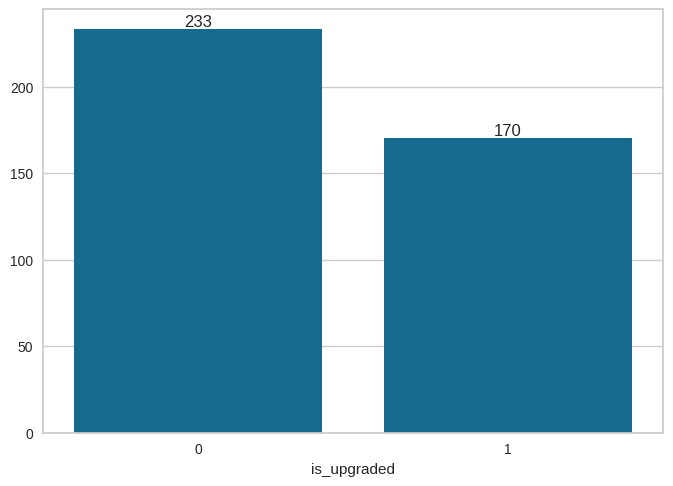

In [4]:
ax = sns.barplot(x=df['is_upgraded'].value_counts().index, y=df['is_upgraded'].value_counts().values)
ax.bar_label(ax.containers[0])
plt.show()

In [5]:
numerical_cols = ['wiek', 'PSA', 'PSAdensity', 'MRI vol', 'MRI SIZE']
categorical_cols = ['MRI Pirads', 'MRI EPE', 'MRI SVI', 'Bx ISUP Grade']

Tuning hyperparameters...



Best hyperparameters: {'classifier__colsample_bytree': 1.0, 'classifier__gamma': 0.2, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Best neg_brier_score score: -0.23173675005244512

Model hyperparameters after tuning: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': 0.2, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_paral

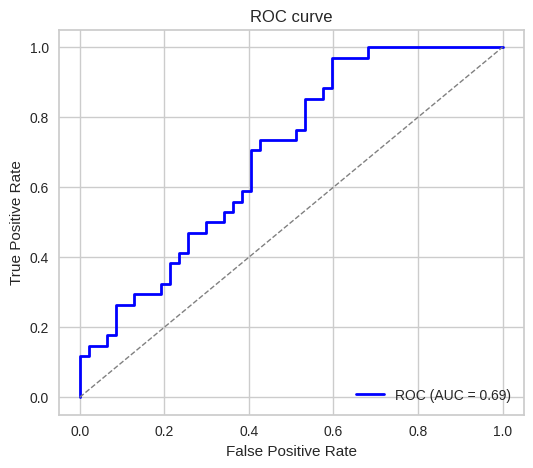

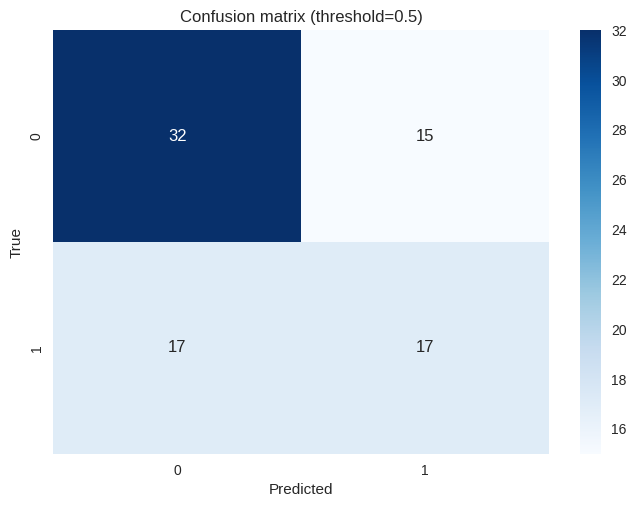

Sensitivity: 0.5000
Specificity: 0.6809
Accuracy: 0.6049%
Preparation of a new explainer is initiated

  -> data              : 403 rows 9 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 403 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x747fde0f42c0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00639, mean = 0.427, max = 0.959
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.836, mean = -0.00531, max = 0.77
  -> model_info        : package sklearn

A new explainer has been created!


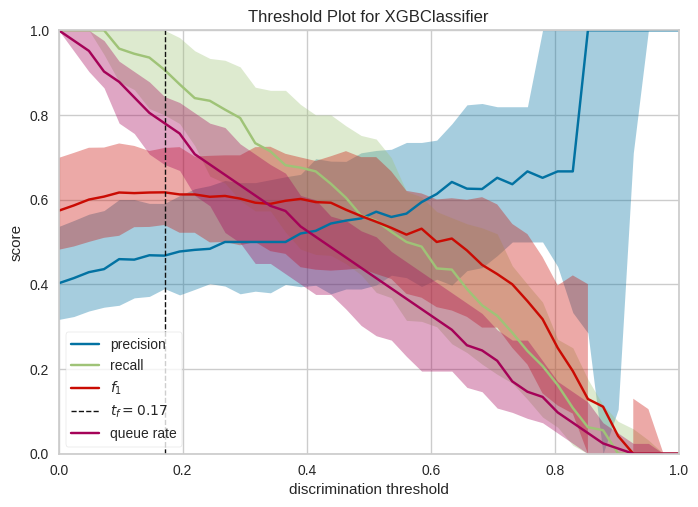

In [6]:
X = df[numerical_cols + categorical_cols]
y = df['is_upgraded']

param_grid = {
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__n_estimators': [200, 400, 800],
    'classifier__max_depth': [3, 6, 9],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}

model = XGBClassifier(random_state=2)

y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, trained_model, best_params = train_and_evaluate_model(model, X, y, numerical_cols, categorical_cols, n_folds=5, tune_params=True, param_grid=param_grid, tuning_scoring='neg_brier_score', tuning_test_size=0.2)
untrained_model = model.set_params(**best_params)

plot_roc(false_positive_rate, true_positive_rate, total_roc_auc)
plot_confusion_matrix(y_true, y_pred)
plot_feature_importances(trained_model, X, y)
plot_discrimination_threshold(untrained_model, X, y)

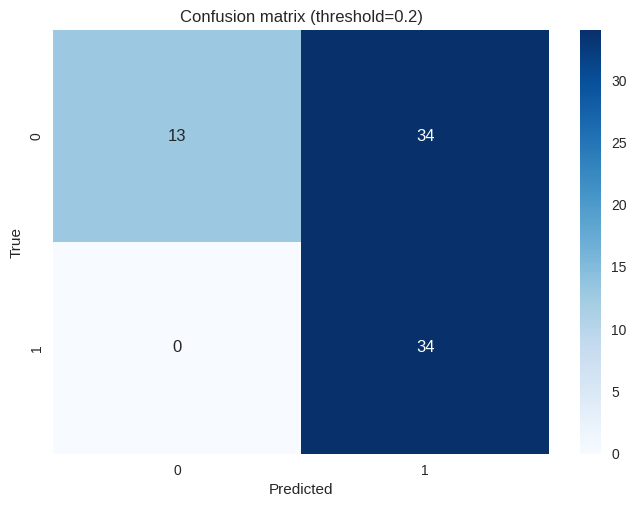

Sensitivity: 1.0000
Specificity: 0.2766
Accuracy: 0.5802%


In [12]:
plot_confusion_matrix(y_true, y_pred_probs=y_pred_probs, threshold=0.2)

# Predictions of upgrade difference

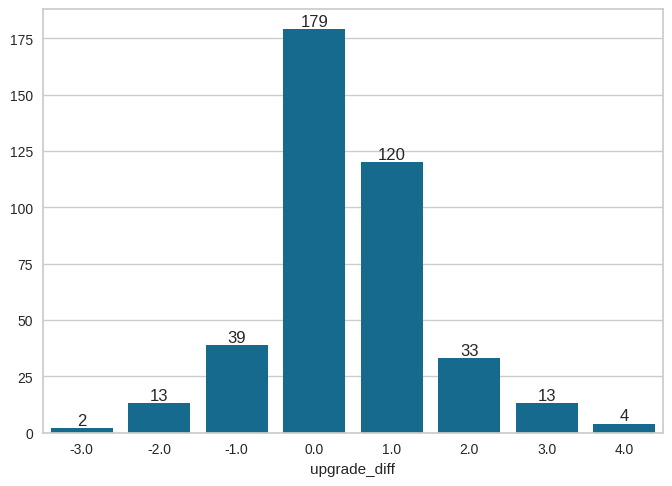

In [13]:
ax = sns.barplot(x=df['upgrade_diff'].value_counts().index, y=df['upgrade_diff'].value_counts().values)
ax.bar_label(ax.containers[0])
plt.show()

In [14]:
X = df[numerical_cols + categorical_cols]
y = df["upgrade_diff"]

param_grid = {
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__n_estimators': [200, 400, 800],
    'classifier__max_depth': [3, 6, 9],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}

model = XGBRegressor(random_state=2)
y_true, y_pred, metrics, model_pipeline, best_params = train_and_evaluate_regression(model, X, y, numerical_cols, categorical_cols, n_folds=5, tune_params=True, param_grid=param_grid, tuning_scoring='neg_mean_squared_error', tuning_test_size=0.2)
# y_true, y_pred, metrics, model_pipeline, best_params = train_and_evaluate_regression(model, X, y, numerical_cols, categorical_cols, n_folds=5, tune_params=False)

Tuning hyperparameters...



/home/adammie/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



Best hyperparameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.2, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 9, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best neg_mean_squared_error score: -0.8425214618584266

Model hyperparameters after tuning: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': 0.2, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'nu

In [15]:
df_md = pd.DataFrame({'True Values': y_true, 'Predicted Values': y_pred}).head(10).reset_index(drop=True)
markdown_str = df_md.to_markdown(index=False)
print(markdown_str)


|   True Values |   Predicted Values |
|--------------:|-------------------:|
|             1 |          1.13782   |
|            -1 |         -0.144731  |
|             1 |          0.669611  |
|             0 |          0.0090763 |
|             1 |          1.20638   |
|             2 |          1.41973   |
|             0 |          0.687312  |
|             0 |          0.0381611 |
|             0 |          0.529309  |
|             0 |          0.938786  |
